# Linear regression with MCMC

Author(s): Shajib

In this notebook, we will fit a linear model (which simply means a straight
line) to some data points. This fitting process has a fancy name:
"Linear regression." We will fit the model to daily temperature values
for a given city and then **use the best-fit model to predict** future
temperatures. The data points have uncertainties that correspond to the 68 percentiles of the range of temperature fluctuations within a day. We want to fit a model

 $T(d) = m d + b,$

where $d$ is the day number (independent variable) and $T$ is the temperature (dependent variable). The model parameters are the slope of
the linear relation $m$ and the offset $b$. For a given set of $N$ data points $T_i$, $\sigma_{T,i}$, $d_i$ with $i=1,\dots,N$, we want to find the best fit values for $m$ and $b$, and **also their uncertainties**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Retrieving daily temperature data

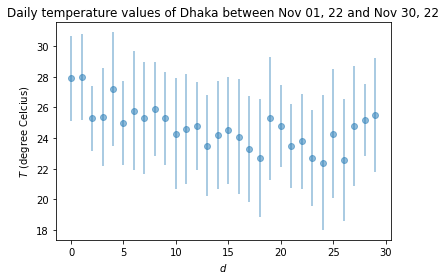

In [129]:
from city_temperatures import CityTemperatures
from datetime import datetime

# Take a city name that has the first two letters common with your name.
# If the plot below comes out empty, then chances are that this city is not
# very well-known, in that case try choosing a different city.
city_name = 'Dhaka'
city_temparatures = CityTemperatures(city_name)

start_date = datetime(2022, 11, 1)
end_date = datetime(2022, 11, 30)

dates, temperature_average, temperature_range = city_temparatures\
    .get_temperatures(start_date, end_date)


day_index = range(len(dates))
temperature = temperature_average
sigma_temperature = 0.34 * temperature_range

x = day_index
y = temperature
yerr = sigma_temperature

fig, ax = plt.subplots()
ax.errorbar(x=day_index,
            y=temperature,
            yerr=sigma_temperature,
            ls='none', marker='o', alpha=0.5)

ax.set_xlabel(r'$d$')
ax.set_ylabel(r'$T$ (degree Celcius)')
ax.set_title(f'Daily temperature values of {city_name} between '
             f'{start_date.strftime("%b %d, %y")} and '
             f'{end_date.strftime("%b %d, %y")}')
plt.show()

In [4]:
m_guess = -0.8
b_guess = 29
f_guess = 0.525

## The Bayesian way of linear regression

We will take the Bayesian approach, which is more common in
recent Astronomy. The other way is called the Frequentist approach. You
may read [this blog post](https://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) later on your own time to understand the distinctions.

A quick practical distinction to remember is that the Frequentist approach
only considers the likelihood function, whereas the Bayesian approach also considers a prior probability function. Both approaches can give you parameter uncertainties.

We will first define some functions to compute the likelihood, prior, and 
posterior probabilities given model parameters. The logarithms of these values are calculated to have better computational accuracies. Otherwise, these values can be very small and vulnerable to floating point error. Then, we will use the MCMC sampling software `emcee` to obtain the posterior probability distribution function (PDF) of the model parameters. Sampling from an unknown distribution makes the distribution known through the distribution of the sampled points, for that reason you would want to sample a large number of points to achieve higher numerical accuracy.


Write down the equations for the log likelihood term in your case.

...

Describe what prior(s) you are choosing on your model parameters.

...


(For reference, here is an example code explained on the `emcee` [website](https://emcee.readthedocs.io/en/stable/tutorials/line/).)

In [154]:
def get_log_likelihood(params,x,y,yerr):
    """
    Compute the log likelihood value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log likelihood value
    :rtype: float
    """
    # write code
    m, b, log_f = params
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


def get_log_prior(params):
    """
    Get the log prior value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log prior value
    :rtype: float
    """
    # write code
    m, b, log_f = params
    if -5.0 < m < 0.5 and 20.0 < b < 35.0 and -50 < log_f < 0:
        return 0.0
    return -np.inf

def get_log_posterior(params,x,y,err):
    """
    Compute the log posterior value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log posterior value
    :rtype: float
    """
    log_prior = get_log_prior(params)

    if np.isinf(log_prior):
        return -np.inf
    else:
        return get_log_likelihood(params,x,y,err) + log_prior

**Now, we will create an instance of the `emcee.EnsembleSampler` class and
perform the MCMC sampling.**

In [155]:
import emcee

init_params = np.array([m_guess,b_guess,np.log(f_guess)]) # insert your initial guess for the model parameters
num_step = 1000
num_walkers = 40
num_params = len(init_params)
init_walker_positions = np.random.normal(loc=init_params, scale=1e-4,
                                        size=(num_walkers, num_params))

sampler = emcee.EnsembleSampler(num_walkers, num_params,
                                get_log_posterior,args = (x,y,yerr))

sampler.run_mcmc(init_walker_positions, num_step, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.64it/s]


**`emcee` employs multiple parallel walkers (set by the variable
`num_walkers`). Let's plot how these walkers have moved around in the
parameter space along the sampling steps.**

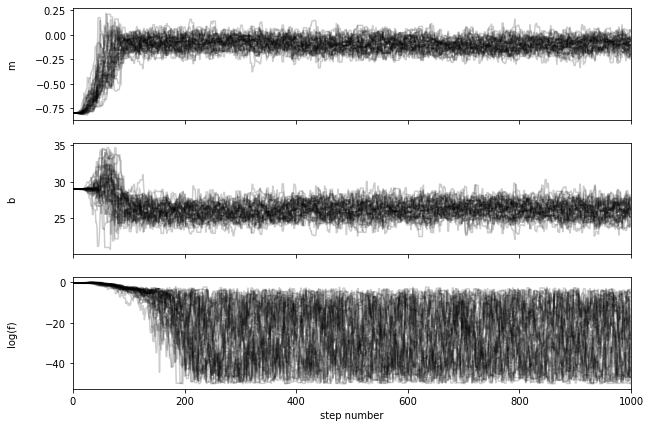

In [156]:
fig, axes = plt.subplots(num_params, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels = ["m","b","log(f)"] # make a list of strings for the labels of your model parameters

for i in range(num_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In the above plot:

1. Notice that the chain (which means the walker positions along the steps) has stabilized after a certain step number. This stabilization is called the convergence.
2. There is an initial period where the chain has some memory of the
initial position. The period until this memory has been lost is called the
burnin.
3. We want to throw away all the steps until convergence has been reached.
Set the value for the `discard` variable to that initial number of steps to be thrown away.
4. You would also want to thin the chain because each successive step is
correlated with the previous, but you want to have *independent* or *non-correlated* sampled points to provide you the posterior probability
distribution. That's done using the `thin` variable below.

In [157]:
from IPython.display import display, Math

discard = 200
flat_samples = sampler.get_chain(discard=discard, thin=15, flat=True)

for i in range(num_params):
    percentile_16, median, percentile_84 = np.percentile(
        flat_samples[:, i], [16, 50, 84])

    text = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}"
    text = text.format(median,
                       median - percentile_16,
                       percentile_84 - median,
                       labels[i])
    display(Math(text))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Visualizing the posterior PDF of the model parameters

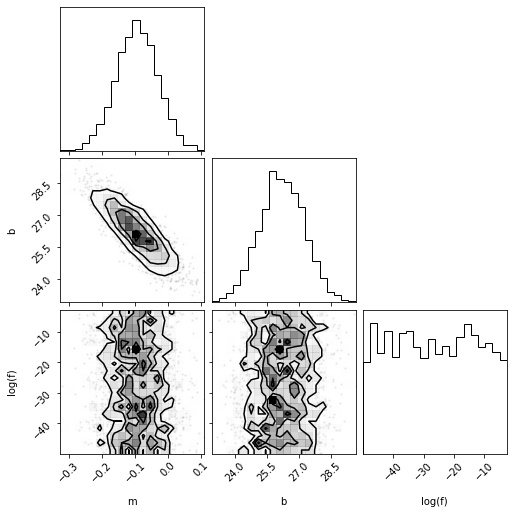

In [99]:
import corner

corner.corner(flat_samples, labels=labels);

The above plot is called the corner plot. The 1D histograms along the diagonals are the 1D marginalized PDF for each parameter and give you the best-fit values and uncertainties. The 2D contours show you the joint distribution of a pair of model parameters. What does it mean that this 2D distribution has an elliptical shape oriented diagonally?

Answer: ...

### Visualizing our model fit

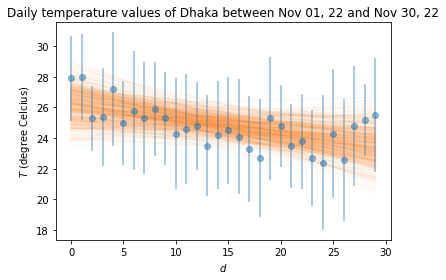

In [100]:
indices = np.random.randint(len(flat_samples), size=500)

fig, ax = plt.subplots()

lines = []

for n in indices:
    sample = flat_samples[n]
    param_1 = sample[0]
    param_2 = sample[1]

    line = param_1*x + param_2 # write code to compute the model line for param_1 and param_2
    lines.append(line)

    ax.plot(day_index, line,
             "C1", alpha=0.03)

ax.errorbar(day_index, temperature, yerr=sigma_temperature,
             ls='none', marker='o', alpha=0.5)

ax.set_xlabel(r'$d$')
ax.set_ylabel(r'$T$ (degree Celcius)')
ax.set_title(f'Daily temperature values of {city_name} between '
             f'{start_date.strftime("%b %d, %y")} and '
             f'{end_date.strftime("%b %d, %y")}')
plt.show()

**In the above figure, how would you interpret the higher-density regions of the orange lines (the region with a deeper shade of orange)?**

Answer: ...

### Below is an alternative way to visualize the uncertainty of fitted model.

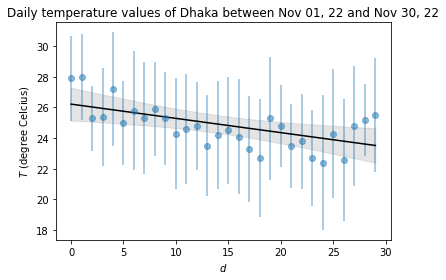

In [101]:
mean_line = np.mean(lines, axis=0)
sigma_line = np.std(lines, axis=0)

fig, ax = plt.subplots()

ax.errorbar(day_index, temperature, yerr=sigma_temperature,
             ls='none', marker='o', alpha=0.5)

ax.plot(day_index, mean_line, 'k-')
ax.fill_between(day_index,
                y1=mean_line+sigma_line,
                y2=mean_line-sigma_line,
                color='grey', alpha=0.2
                )

ax.set_xlabel(r'$d$')
ax.set_ylabel(r'$T$ (degree Celcius)')
ax.set_title(f'Daily temperature values of {city_name} between '
             f'{start_date.strftime("%b %d, %y")} and '
             f'{end_date.strftime("%b %d, %y")}')
plt.show()

## Did we choose our priors appropriately?

If you are like me when I ran the above procedure for the first time, then you have chosen uniform priors on $m$ and $b$, thinking these priors are uninformative. They are actually not uninformative. Let's see how.

In [103]:
import random

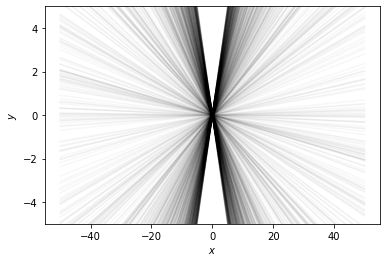

In [104]:
# create 1000 random samples of m ~ U(-1, 1) and set b = 0
m = random.sample(sorted(np.random.uniform(-1,1,2000)), 1000) # m ~ U(-1, 1)
b = 0

x = np.linspace(-50, 50, 100)

fig, ax = plt.subplots()

for i in range(len(m)):
    ax.plot(x, x*m[i]+b, 'k-', alpha=0.03)

ax.set_ylim(-5, 5)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$');

**Is there a preferred alignment in the lines? Is this what you intended when
you imagined an uninformative prior on the slope of the line?**

Answer: ...

To have uninformative priors on $m$ and $b$, you would need to put uniform
priors on $\theta = \tan^{-1} m$ and $b_{\perp} = b \cos \theta$. You can see [here](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) later
for an explanation on why these choices make the prior uninformative.

Now, let's take $\theta$ and $b_{\perp}$ as the parameters that are sampled with uniform prior in the MCMC. However, we are still working with the model:
$T(d) = md + b$.

Rewrite the likelihood and prior functions in terms of the new
model parameter definitions. Then, run the MCMC sampling with `emcee`. Then, convert the $\theta$ and $b_{\perp}$ posterior distributions into $m$ and $b$ posterior distributions. Compare the 1D marginalized values of $m$ and $b$ with those you obtained with the previous prior.

In [120]:
# write code. You may use multiple notebook cells as necessary.
import math

theta_guess = math.pi + np.arctan(m_guess)
bperp_guess = b_guess*np.cos(theta_guess)

print(theta_guess)

2.4668517113662403


In [158]:
def get_log_likelihood(params,x,y,yerr):
    """
    Compute the log likelihood value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log likelihood value
    :rtype: float
    """
    # write code
    theta, bperp, log_f = params
    model = np.tan(theta) * x + bperp/np.cos(theta)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


def get_log_prior(params):
    """
    Get the log prior value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log prior value
    :rtype: float
    """
    # write code
    theta, bperp, log_f = params
    if 140*math.pi/180.0 < theta < 200*math.pi/180.0 and -30.31 < bperp < -3.473 and -50 < log_f < 0:
        return 0.0
    return -np.inf

def get_log_posterior(params,x,y,err):
    """
    Compute the log posterior value.
    :param params: array containing model parameters
    :type params: np.array
    :return: log posterior value
    :rtype: float
    """
    log_prior = get_log_prior(params)

    if np.isinf(log_prior):
        return -np.inf
    else:
        return get_log_likelihood(params,x,y,err) + log_prior

In [159]:
import emcee


init_params = np.array([theta_guess,bperp_guess,np.log(f_guess)]) # insert your initial guess for the model parameters
num_step = 1000
num_walkers = 40
num_params = len(init_params)
init_walker_positions = np.random.normal(loc=init_params, scale=1e-4,
                                        size=(num_walkers, num_params))

sampler = emcee.EnsembleSampler(num_walkers, num_params,
                                get_log_posterior,args = (x,y,yerr))

sampler.run_mcmc(init_walker_positions, num_step, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.58it/s]


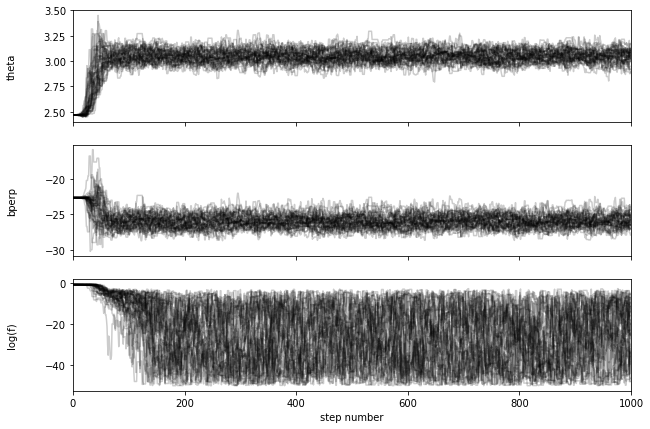

In [160]:
fig, axes = plt.subplots(num_params, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels = ["theta","bperp","log(f)"] # make a list of strings for the labels of your model parameters

for i in range(num_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [163]:
from IPython.display import display, Math

discard = 200
flat_samples = sampler.get_chain(discard=discard, thin=15, flat=True)

for i in range(num_params):
    percentile_16, median, percentile_84 = np.percentile(
        flat_samples[:, i], [16, 50, 84])

    text = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}"
    text = text.format(median,
                       median - percentile_16,
                       percentile_84 - median,
                       labels[i])
    display(Math(text))

conv_labels = ["m","b","log(f)"]

for i in range(num_params):
    percentile_16, median, percentile_84 = np.percentile(
        flat_samples[:, i], [16, 50, 84])
    conv = [percentile_16, median, percentile_84]
    if i==0:
        theta_med = median
        conv = np.tan(conv)
    elif i==1:
        conv = conv/np.cos(theta_med)
  
    text = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}"
    text = text.format(conv[0],
                       conv[0] - conv[1],
                       conv[2] - conv[0],
                       conv_labels[i])
    display(Math(text))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

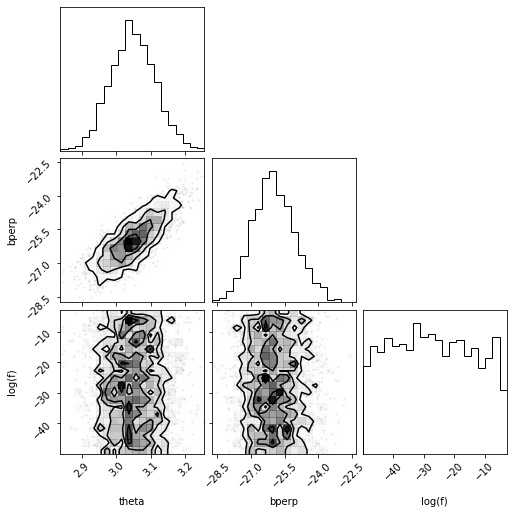

In [153]:
import corner

corner.corner(flat_samples, labels=labels);

# Prediction using your model

1. Using your best-fit model, predict the temperature in your chosen city on Dec 7, 2022. Your prediction should include uncertainty.
2. Similarly, predict the temperatures on Jun 30, 2023
and Oct 31, 2023. Are they reasonable predictions? If not, could you think about why?

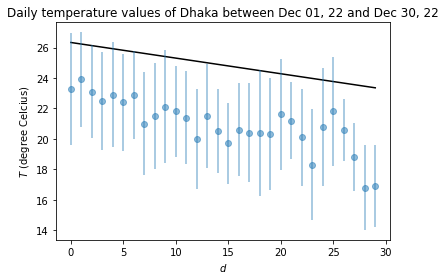

In [29]:
# write code to make your predictions

city_name = 'Dhaka'
city_temparatures = CityTemperatures(city_name)

start_date = datetime(2022, 12, 1)
end_date = datetime(2022, 12, 30)

dates, temperature_average, temperature_range = city_temparatures\
    .get_temperatures(start_date, end_date)


day_index = range(len(dates))
temperature = temperature_average
sigma_temperature = 0.32 * temperature_range

fig, ax = plt.subplots()

ax.plot(day_index,mean_line,'k-')

ax.errorbar(x=day_index,
            y=temperature,
            yerr=sigma_temperature,
            ls='none', marker='o', alpha=0.5)

ax.set_xlabel(r'$d$')
ax.set_ylabel(r'$T$ (degree Celcius)')
ax.set_title(f'Daily temperature values of {city_name} between '
             f'{start_date.strftime("%b %d, %y")} and '
             f'{end_date.strftime("%b %d, %y")}')
plt.show()